In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import Dense, SimpleRNN
from nltk.tokenize import word_tokenize
import utils

In [2]:
# Read the Excel file into a pandas DataFrame
df = pd.read_csv('Dataset/Text_Emotion_Data.csv')


# Remove non-letter characters from the 'Text' column
# df['Text'] = df['Text'].str.replace(r'[^a-zA-Z]', '', regex=True)
df['Text'] = df['Text'].str.replace(r'[^a-zA-Z\s]', '',regex=False)

# Remove short words (with length ≤ 2) from the 'Text' column
df['Text'] = df['Text'].str.split().apply(lambda x: ' '.join([word for word in x if len(word) > 2]))




# Read the stopwords from the file
stopwords = set(open('Dataset/stopwords.txt', 'r').read().split())
df['Text'] = df['Text'].apply(lambda x: utils.RemoveStops(x, stopwords))



# Tokenize the 'Text' column
df['Tokenized_Text'] = df['Text'].apply(word_tokenize)


# Convert word sequences to integer sequences
integer_sequences = []

# Tokenize the text and add padding
for sequence in df['Tokenized_Text']:
    # Add the tokenized words to the integer sequences
    integer_sequence = [word.lower() for word in sequence if word.lower() not in stopwords]
    integer_sequences.append(integer_sequence)

# Determine the maximum sequence length
max_length = max(len(sequence) for sequence in integer_sequences)

# Pad the sequences with zeros to have the same length
padded_sequences = []
for sequence in integer_sequences:
    # Check if padding is needed
    if len(sequence) < max_length:
        # Calculate the number of padding tokens needed
        num_padding = max_length - len(sequence)
        
        # Add padding tokens (zeros) to the sequence
        padded_sequence = sequence + [0] * num_padding
    else:
        # No padding needed
        padded_sequence = sequence
    
    padded_sequences.append(padded_sequence)

# Add the padded sequences as a new column in the DataFrame
df['Padded_Text'] = padded_sequences

# Call the function with your dataset
word_dictionary = utils.create_word_dictionary(df['Padded_Text'])

# Print the number of unique words
print("Number of Unique Words:", len(word_dictionary))




print(max_length)
df

Number of Unique Words: 6523
19


,Text,Label,Tokenized_Text,Padded_Text
0,feel like finally position decide whether indu...,joy,"[feel, like, finally, position, decide, whethe...","[feel, like, finally, position, decide, whethe..."
1,feel resigned lot life watch everyone else bec...,sadness,"[feel, resigned, lot, life, watch, everyone, e...","[feel, resigned, lot, life, watch, everyone, e..."
2,feel thrilled presence eyes feel belief peace ...,joy,"[feel, thrilled, presence, eyes, feel, belief,...","[feel, thrilled, presence, eyes, feel, belief,..."
3,finally sit feel sweet release notice misplace...,joy,"[finally, sit, feel, sweet, release, notice, m...","[finally, sit, feel, sweet, release, notice, m..."
4,feel bit jealous trying date long time ago doe...,anger,"[feel, bit, jealous, trying, date, long, time,...","[feel, bit, jealous, trying, date, long, time,..."
...,...,...,...,...
3245,want say things want say without feeling embar...,sadness,"[want, say, things, want, say, without, feelin...","[want, say, things, want, say, without, feelin..."
3246,feel need generous offerings especially huntin...,love,"[feel, need, generous, offerings, especially, ...","[feel, need, generous, offerings, especially, ..."
3247,sitting belmont library listening hold tight e...,sadness,"[sitting, belmont, library, listening, hold, t...","[sitting, belmont, library, listening, hold, t..."
3248,let sad feeling want accepted first home mine,love,"[let, sad, feeling, want, accepted, first, hom...","[let, sad, feeling, want, accepted, first, hom..."


In [3]:
#split to test and train 
X = np.array(df['Padded_Text'].tolist())
labels = df['Label'].values
X_train, X_test, y_train, y_test = utils.split_train_test_data(X, labels)

# Print the shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



X_train shape: (2500, 19)
X_test shape: (750, 19)
y_train shape: (2500,)
y_test shape: (750,)


In [4]:
#make data 3D
X_train = utils.ThreeDim_one_hot_encoder(X_train ,word_dictionary )
X_test = utils.ThreeDim_one_hot_encoder(X_test ,word_dictionary )
print('shape of X_train',X_train.shape)
print('shape of y_train',y_train.shape)
print('shape of X_test',X_test.shape)
print('shape of y_test',y_test.shape)


shape of X_train (2500, 19, 6523)
shape of y_train (2500,)
shape of X_test (750, 19, 6523)
shape of y_test (750,)


In [8]:
labels = df['Label'].values
classes = np.unique(labels)
# Define the model architecture
model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=len(classes), activation='softmax'))
# model.add(Dense(64, activation='relu', input_dim=vocab_size))


# Compile the model
# optimizer = optimizers.Adam(learning_rate=0.01)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on train and test data
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)



Epoch 1/10
79/79 [==============================] - 3s 29ms/step - loss: 1.5648 - accuracy: 0.2648 - val_loss: 1.3834 - val_accuracy: 0.4267
Epoch 2/10
79/79 [==============================] - 2s 20ms/step - loss: 0.7392 - accuracy: 0.7708 - val_loss: 1.3413 - val_accuracy: 0.4893
Epoch 3/10
79/79 [==============================] - 1s 16ms/step - loss: 0.1418 - accuracy: 0.9744 - val_loss: 1.4130 - val_accuracy: 0.5093
Epoch 4/10
79/79 [==============================] - 1s 16ms/step - loss: 0.0271 - accuracy: 0.9984 - val_loss: 1.5490 - val_accuracy: 0.5400
Epoch 5/10
79/79 [==============================] - 1s 17ms/step - loss: 0.0108 - accuracy: 0.9992 - val_loss: 1.5951 - val_accuracy: 0.5320
Epoch 6/10
79/79 [==============================] - 1s 17ms/step - loss: 0.0072 - accuracy: 0.9996 - val_loss: 1.6905 - val_accuracy: 0.5360
Epoch 7/10
79/79 [==============================] - 1s 16ms/step - loss: 0.0052 - accuracy: 0.9992 - val_loss: 1.7665 - val_accuracy: 0.5333
Epoch 8/10
79

24/24 [==============================] - 0s 11ms/step
Train Accuracy: 0.9996
Test Accuracy: 0.5253333333333333
Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       500
           3       1.00      1.00      1.00       500
           4       1.00      1.00      1.00       500

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500

Test Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.61      0.57       150
           1       0.53      0.53      0.53       150
           2       0.47      0.31      0.38       150
           3       0.57      0.72      0.64       150
           4       0.48      0.46      0.47       150

    accuracy     

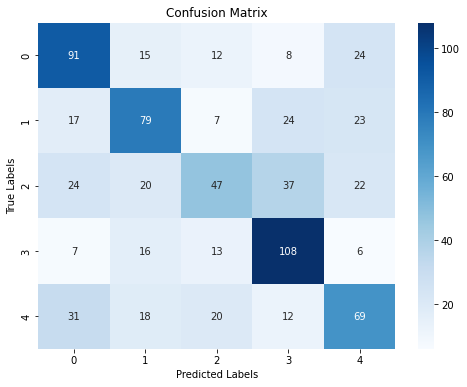

In [10]:

# Get predicted labels
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Convert predictions to class labels
y_train_pred_labels = np.argmax(y_train_pred, axis=1)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred_labels)
test_accuracy = accuracy_score(y_test, y_test_pred_labels)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Generate classification report for train data
train_report = classification_report(y_train, y_train_pred_labels)
print("Train Classification Report:")
print(train_report)

# Generate classification report for test data
test_report = classification_report(y_test, y_test_pred_labels)
print("Test Classification Report:")
print(test_report)

# Calculate confusion matrix for test data
cm = confusion_matrix(y_test, y_test_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()